# Policy gradient algrorithm with BigDL

In [1]:
import random
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

from bigdl.dataset.transformer import Sample
from bigdl.nn.layer import *
from bigdl.util.common import *
from bigdl.optim.optimizer import *
from bigdl.nn.criterion import *

from rl.criterion import *

init_engine()

In [2]:
class PGAgent:
    def __init__(self, state_size, action_size, gamma=0.95):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma  # discount rate
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()

        model.add(Linear(self.state_size, 24))
        model.add(ReLU())

        model.add(Linear(24, 24))
        model.add(ReLU())

        model.add(Linear(24, 1))
        model.add(Sigmoid())
        return model

    def act(self, state):
        result = self.model.forward(state)
        return 1 if result > np.random.random() else 0

In [3]:
def to_RDD(X, y):
    return sc.parallelize(X).zip(sc.parallelize(y)).map(
            lambda x: Sample.from_ndarray(x[0], x[1]))

In [4]:
def play_game(agent, render=False):
    state = env.reset()
    memory = np.array([0,0,0,0])
    actions = np.array([])
    rewards = np.array([])
    for time in range(500):
        if render:
            env.render()
        memory = np.vstack((memory, state))
        action = agent.act(state)
        actions = np.append(actions, action)
        state, reward, done, _ = env.step(action)
        if done:
            reward = -10
        rewards = np.append(rewards, reward)
        if done or time == 498:
            break
    return memory[1:], actions, rewards, time

In [5]:
def running_reward(actions, rewards, gamma):
    result = []
    run_rew = 0
    for action, reward in list(zip(actions, rewards))[::-1]:
        run_rew = run_rew*gamma + reward
        result.append([action, run_rew])
    return np.vstack(result[::-1])

In [6]:
def play_n_games(agent, n=20):
    X_batch = np.array([0,0,0,0])
    y_batch = np.array([0,0])
    results = []
    for i in range(n):
        a, b, c, d = play_game(agent)
        X_batch = np.vstack((X_batch, a))
        y_batch = np.vstack((y_batch, running_reward(b, c, agent.gamma)))
        results.append(d)
    results = np.array(results)
    return X_batch[1:], y_batch[1:], results.mean(),results.var()

In [7]:
env = gym.make('CartPole-v1')
#sc = SparkContext.getOrCreate(create_spark_conf())
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = PGAgent(state_size, action_size)

[2017-11-09 18:23:41,228] Making new env: CartPole-v1


creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createReLU
creating: createLinear
creating: createSigmoid


In [9]:
%%time
import timeit

record = []
exe_times = []
for i in range(100):
   
    start_of_play = timeit.default_timer()
    X_batch, y_batch, result_mean,result_variance = play_n_games(agent,n=5)
    end_of_play = timeit.default_timer()
    
    print "Running update iteration",i+1,"score_mean =",result_mean,"score_variance =",result_variance
    record.append([result_mean, result_variance])
    #if result == 498:
    #    break
    rdd_sample = to_RDD(X_batch, y_batch)
    
    batch_size = X_batch.shape[0] - X_batch.shape[0]%8
    print "using batch_size = ",batch_size
    
    start_of_train = timeit.default_timer()
    optimizer = Optimizer(model=agent.model,
                                  training_rdd=rdd_sample,
                                  criterion=VanillaPGCriterion(size_average=True),
                                  optim_method=Adam(learningrate=0.01),
                                  end_trigger=MaxIteration(1),
                                  batch_size=batch_size)
    agent.model = optimizer.optimize()
    end_of_train = timeit.default_timer()
    exe_time_game_play = end_of_play-start_of_play
    exe_time_train = end_of_train-start_of_train
    exe_times.append([exe_time_game_play,exe_time_train])

Running update iteration 1 score_mean = 19.6 score_variance = 90.24
using batch_size =  96
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 2 score_mean = 21.0 score_variance = 22.4
using batch_size =  104
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 3 score_mean = 26.2 score_variance = 224.16
using batch_size =  136
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 4 score_mean = 28.6 score_variance = 238.64
using batch_size =  144
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 5 score_mean = 29.4 score_variance = 47.44
using batch_size =  152
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: c

Running update iteration 41 score_mean = 76.4 score_variance = 3542.64
using batch_size =  384
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 42 score_mean = 195.4 score_variance = 4927.04
using batch_size =  976
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 43 score_mean = 146.2 score_variance = 2750.56
using batch_size =  736
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 44 score_mean = 236.2 score_variance = 12187.76
using batch_size =  1184
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 45 score_mean = 201.0 score_variance = 15295.6
using batch_size =  1008
creating: createVanillaPGCriterion
creating: createAdam
creating: createMa

Running update iteration 81 score_mean = 428.4 score_variance = 7906.24
using batch_size =  2144
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 82 score_mean = 368.2 score_variance = 29232.16
using batch_size =  1840
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 83 score_mean = 390.2 score_variance = 16525.36
using batch_size =  1952
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 84 score_mean = 401.0 score_variance = 20821.6
using batch_size =  2008
creating: createVanillaPGCriterion
creating: createAdam
creating: createMaxIteration
creating: createOptimizer
Running update iteration 85 score_mean = 498.0 score_variance = 0.0
using batch_size =  2488
creating: createVanillaPGCriterion
creating: createAdam
creating: createM

# plots

(100, 2)


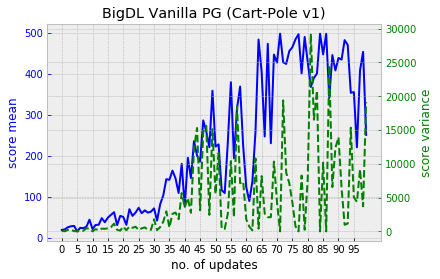

In [12]:
%matplotlib inline
import seaborn
plt.style.use('bmh')
arr = np.asarray(record)
print arr.shape
fig, ax1 = plt.subplots()
ind=np.arange(0,arr.shape[0],1)
#t = np.arange(0.01, 10.0, 0.01)
#s1 = np.exp(t)
ax1.plot(ind,arr[:,0], 'b-')
ax1.set_xlabel('no. of updates')
ax1.set_xticks(ind[::5])
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('score mean', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(ind,arr[:,1], 'g--')
ax2.set_ylabel('score variance', color='g')
ax2.tick_params('y', colors='g')
plt.grid(True)
#fig.tight_layout()
plt.title('BigDL Vanilla PG (Cart-Pole v1)');

(100, 2)


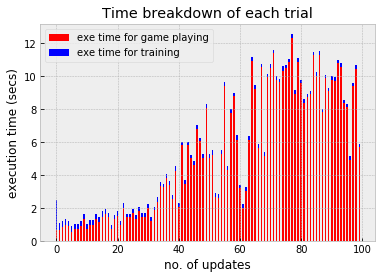

In [13]:
plt.style.use('bmh')
exe_arr = np.asarray(exe_times)
print exe_arr.shape

ind=np.arange(0,arr.shape[0],1)
width=0.5
p1 = plt.bar(ind, exe_arr[:,0], width,color='r')
p2 = plt.bar(ind, exe_arr[:,1], width,color='b',bottom=exe_arr[:,0])
#p3 = plt.bar(ind, exe_arr[:,2], width, color='b',bottom=exe_arr[:,1])
             
plt.xlabel('no. of updates')
plt.ylabel('execution time (secs)')
plt.title('Time breakdown of each trial')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0],p3[0]), ('exe time for game playing', 'exe time for data preparation','exe time for training'))
plt.legend((p1[0], p2[0]), ('exe time for game playing','exe time for training'))